In [1]:
%matplotlib inline
#!pip install pennylane
#!pip install qulacs pennylane-qulacs
#!pip install seaborn
#!pip install lightning
#!pip install ipynbname

In [2]:
#from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm
#import pennylane as qml
#from pennylane.utils import _flatten, unflatten
#from pennylane import GradientDescentOptimizer
import copy
#from momentum_qng import MomentumQNGOptimizer 

In [3]:
depth = 4


In [4]:
stepsizes = [0.01,0.025]
stepsizes += [0.05 + 0.05*(x) for x in range(30)]

In [5]:
sessions = [
    {"optimizer" : "QNGOptimizer",
     "params" : {"approx" : 'block-diag', "lam" : 0.},
     "params_name" : "approx='block-diag', $\mathit{"+ chr(955) + "}$=0.",
     "stepsizes" : [0.01,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25],
     "dev" : "default.qubit"},
    {"optimizer" :  "AdamOptimizer",
     "params" : {"beta1" : 0.9, "beta2" : 0.99, "epsilon" : 1.0e-8},
     "params_name" : "$\mathit{"+ chr(946) + "}_1$=0.9, $\mathit{"+ chr(946) + "}_2$=0.99, $\mathit{"+ chr(949) +"}$=$10^{-8}$",
     "stepsizes" : [0.01,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25],
     "dev" : "default.qubit"},
    {"optimizer" :  "MomentumOptimizer",
     "params" : {"momentum" : 0.9},
     "params_name" : "$\mathit{"+ chr(961) +"}$=0.9",
     "stepsizes" : [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.125],
     "dev" : "default.qubit"},
    {"optimizer" :  "MomentumQNGOptimizer",
     "params" : {"momentum" : 0.9, "approx" : 'block-diag', "lam" : 0.},
     "params_name" : "$\mathit{"+ chr(961) +"}$=0.9, approx='block-diag', $\mathit{"+ chr(955) + "}$=0",
     "stepsizes" : [0.01,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25],
     "dev" : "default.qubit"},
    {"optimizer" : "QNGOptimizer",
     "params" : {"approx" : 'block-diag', "lam" : 0.5},
     "params_name" : "approx='block-diag', $\mathit{"+ chr(955) + "}$=0.5",
     "stepsizes" : [0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55],
     "dev" : "default.qubit"},
    {"optimizer" :  "MomentumQNGOptimizer",
     "params" : {"momentum" : 0.9, "approx" : 'block-diag', "lam" : 0.5},
     "params_name" : "$\mathit{"+ chr(961) +"}$=0.9, approx='block-diag', $\mathit{"+ chr(955) + "}$=0.5",
     "stepsizes" : [0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35],
     "dev" : "default.qubit"},
    {"optimizer" :  "AdamOptimizer",
     "params" : {"beta1" : 0.9, "beta2" : 0.99, "epsilon" : 1.0e-8},
     "params_name" : "$\mathit{"+ chr(946) + "}_1$=0.9, $\mathit{"+ chr(946) + "}_2$=0.99, $\mathit{"+ chr(949) +"}$=$10^{-8}$",
     "stepsizes" : stepsizes,
     "dev" : "default.qubit"},    
    
]

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape se

In [6]:
init_count = 200
steps = 200

cost_tolerance = 0.01
cost_tolerance_count = 3

seed_value = 34093197

init_params_array = []
np.random.seed(seed_value)
for i in range(init_count):
    gam = np.random.random(depth)
    alp = np.random.random(depth)
    init_params_array.append(np.array([gam, alp], requires_grad=True))

In [7]:
sessions_quality = []

file1_name = "../data/all_mom/qaoa_mvc_quality_depth=4_2024-09-14.dat"
file1 = open(file1_name, "r")

f1lines = file1.readlines()

stepsizes_count = 11
qng_quality = []
for i in range(stepsizes_count):
    stepsize_quality = [0]*init_count
    qng_quality.append(stepsize_quality)
adam_quality = []
for i in range(stepsizes_count):
    stepsize_quality = [0]*init_count
    adam_quality.append(stepsize_quality)
mom_quality = []
for i in range(stepsizes_count):
    stepsize_quality = [0]*init_count
    mom_quality.append(stepsize_quality)
momqng_quality = []
for i in range(stepsizes_count):
    stepsize_quality = [0]*init_count
    momqng_quality.append(stepsize_quality)

for i in range(0,len(f1lines)):
    line1 = f1lines[i].split()
    for j in range(1,12):
         #print(j,line1[j])
         qng_quality[j-1][i-1] = float(line1[j])
    for j in range(12,23):
         adam_quality[j-12][i-1] = float(line1[j])
    for j in range(23,34):
         mom_quality[j-23][i-1] = float(line1[j])
    for j in range(34,45):
         momqng_quality[j-34][i-1] = float(line1[j])

sessions_quality.append(qng_quality)
sessions_quality.append(adam_quality)
sessions_quality.append(mom_quality)
sessions_quality.append(momqng_quality)




In [8]:
file1_name = "../data/qng/qaoa_mvc_qng_quality_depth=4_2025-05-13.dat"
file1 = open(file1_name, "r")

f1lines = file1.readlines()

stepsizes_count = 13
qng1_quality = []
for i in range(stepsizes_count):
    stepsize_quality = [0]*init_count
    qng1_quality.append(stepsize_quality)

for i in range(0,len(f1lines)):
    line1 = f1lines[i].split()
    for j in range(1,stepsizes_count+1):
         #print(j,line1[j])
         qng1_quality[j-1][i-1] = float(line1[j])

sessions_quality.append(qng1_quality)

file1_name = "../data/momqng/qaoa_mvc_momqng_quality_depth=4_2025-05-12.dat"
file1 = open(file1_name, "r")

f1lines = file1.readlines()

stepsizes_count = 9
momqng1_quality = []
for i in range(stepsizes_count):
    stepsize_quality = [0]*init_count
    momqng1_quality.append(stepsize_quality)

for i in range(0,len(f1lines)):
    line1 = f1lines[i].split()
    for j in range(1,stepsizes_count+1):
         #print(j,line1[j])
         momqng1_quality[j-1][i-1] = float(line1[j])

sessions_quality.append(momqng1_quality)

file1_name = "../data/adam/qaoa_mvc_adam_quality_depth=4_2025-05-12.dat"
file1 = open(file1_name, "r")

f1lines = file1.readlines()

stepsizes_count = 32
adam1_quality = []
for i in range(stepsizes_count):
    stepsize_quality = [0]*init_count
    adam1_quality.append(stepsize_quality)


for i in range(0,len(f1lines)):
    line1 = f1lines[i].split()
    for j in range(1,stepsizes_count+1):
         #print(j,line1[j])
         adam1_quality[j-1][i-1] = float(line1[j])

sessions_quality.append(adam1_quality)

In [9]:
sessions_steps = []

file1_name = "../data/all_mom/qaoa_mvc_steps_depth=4_2024-09-14.dat"

file1 = open(file1_name, "r")

f1lines = file1.readlines()

stepsizes_count = 11
qng_steps = []
for i in range(stepsizes_count):
    stepsize_steps = [0]*init_count
    qng_steps.append(stepsize_steps)
adam_steps = []
for i in range(stepsizes_count):
    stepsize_steps = [0]*init_count
    adam_steps.append(stepsize_steps)
mom_steps = []
for i in range(stepsizes_count):
    stepsize_steps = [0]*init_count
    mom_steps.append(stepsize_steps)
momqng_steps = []
for i in range(stepsizes_count):
    stepsize_steps = [0]*init_count
    momqng_steps.append(stepsize_steps)


for i in range(0,len(f1lines)):
    line1 = f1lines[i].split()
    for j in range(1,12):
         qng_steps[j-1][i-1] = float(line1[j])
    for j in range(12,23):
         adam_steps[j-12][i-1] = float(line1[j])
    for j in range(23,34):
         mom_steps[j-23][i-1] = float(line1[j])
    for j in range(34,45):
         momqng_steps[j-34][i-1] = float(line1[j])

sessions_steps.append(qng_steps)
sessions_steps.append(adam_steps)
sessions_steps.append(mom_steps)
sessions_steps.append(momqng_steps)




In [10]:
file1_name = "../data/qng/qaoa_mvc_qng_steps_depth=4_2025-05-13.dat"
file1 = open(file1_name, "r")

f1lines = file1.readlines()

stepsizes_count = 13
qng1_steps = []
for i in range(stepsizes_count):
    stepsize_steps = [0]*init_count
    qng1_steps.append(stepsize_steps)

for i in range(0,len(f1lines)):
    line1 = f1lines[i].split()
    for j in range(1,stepsizes_count+1):
         #print(j,line1[j])
         qng1_steps[j-1][i-1] = float(line1[j])

sessions_steps.append(qng1_steps)

file1_name = "../data/momqng/qaoa_mvc_momqng_steps_depth=4_2025-05-12.dat"
file1 = open(file1_name, "r")

f1lines = file1.readlines()

stepsizes_count = 9
momqng1_steps = []
for i in range(stepsizes_count):
    stepsize_steps = [0]*init_count
    momqng1_steps.append(stepsize_steps)

for i in range(0,len(f1lines)):
    line1 = f1lines[i].split()
    for j in range(1,stepsizes_count+1):
         #print(j,line1[j])
         momqng1_steps[j-1][i-1] = float(line1[j])

sessions_steps.append(momqng1_steps)

file1_name = "../data/adam/qaoa_mvc_adam_steps_depth=4_2025-05-12.dat"
file1 = open(file1_name, "r")

f1lines = file1.readlines()

stepsizes_count = 32
adam1_steps = []
for i in range(stepsizes_count):
    stepsize_steps = [0]*init_count
    adam1_steps.append(stepsize_steps)


for i in range(0,len(f1lines)):
    line1 = f1lines[i].split()
    for j in range(1,stepsizes_count+1):
         #print(j,line1[j])
         adam1_steps[j-1][i-1] = float(line1[j])

sessions_steps.append(adam1_steps)

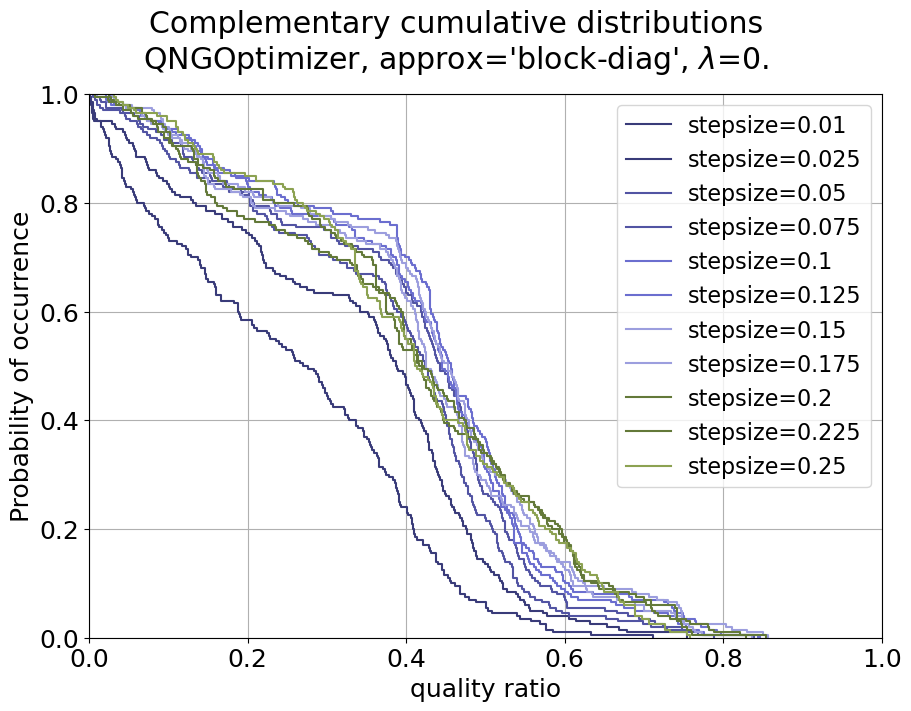

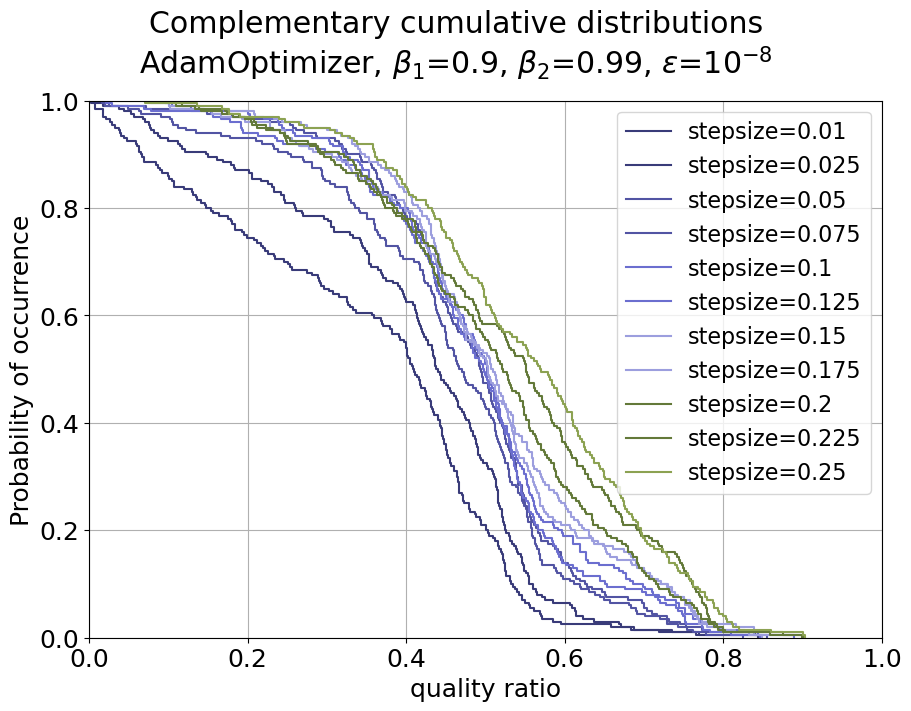

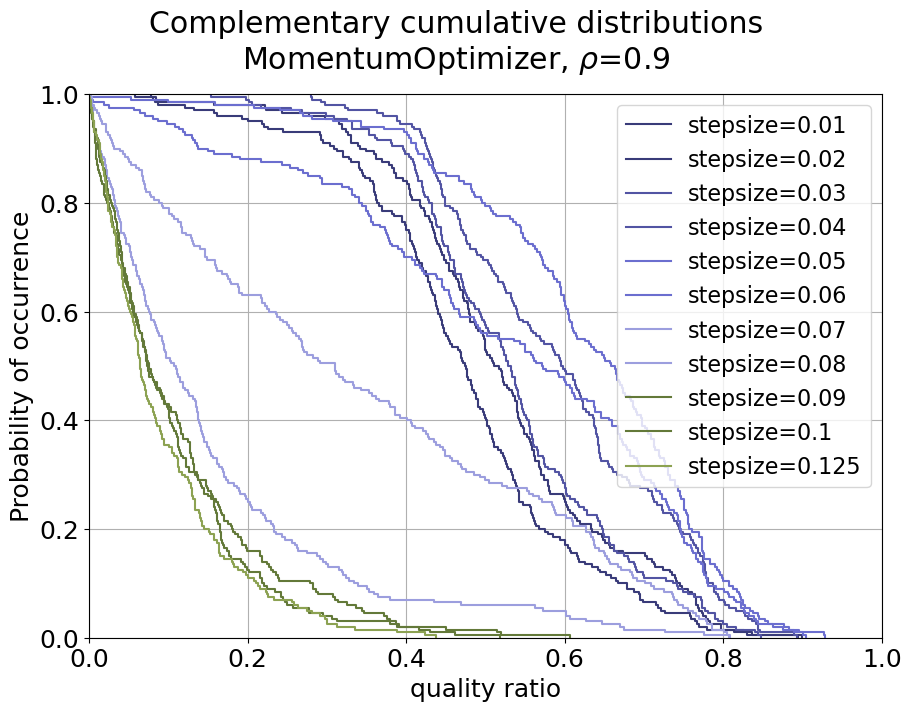

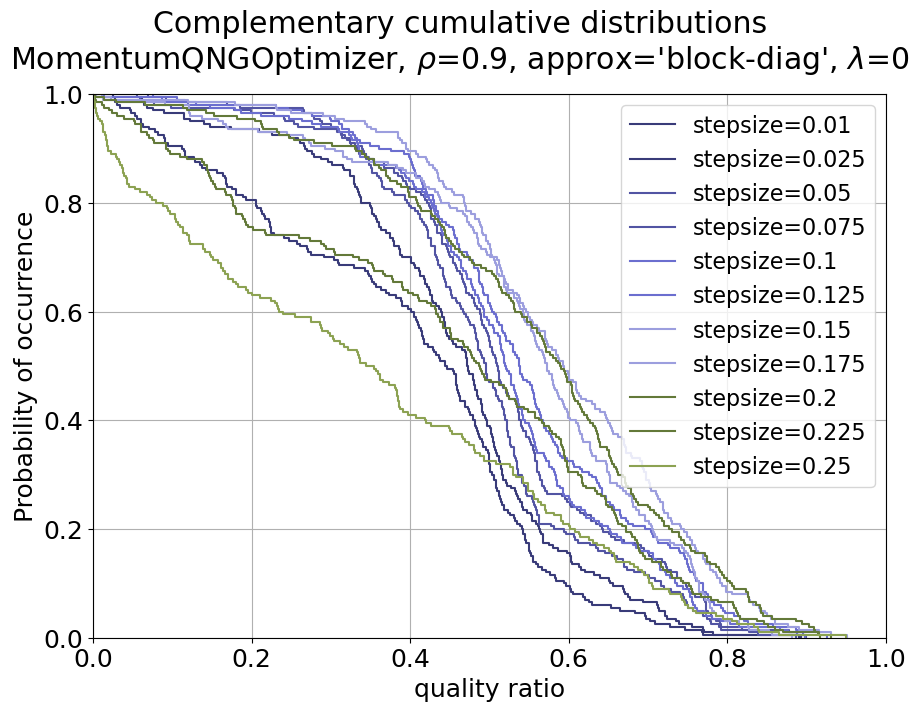

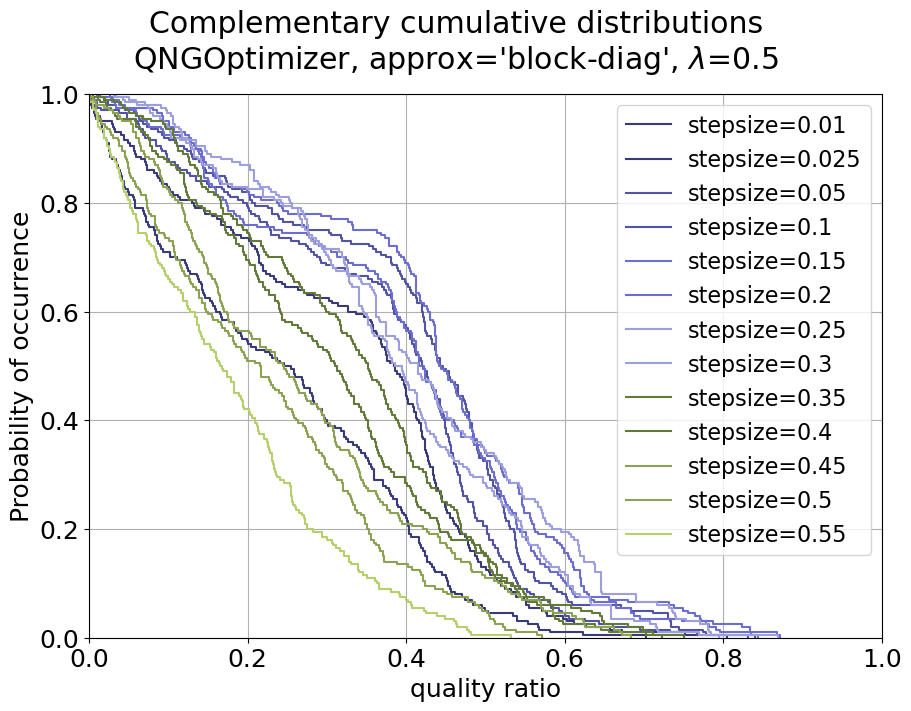

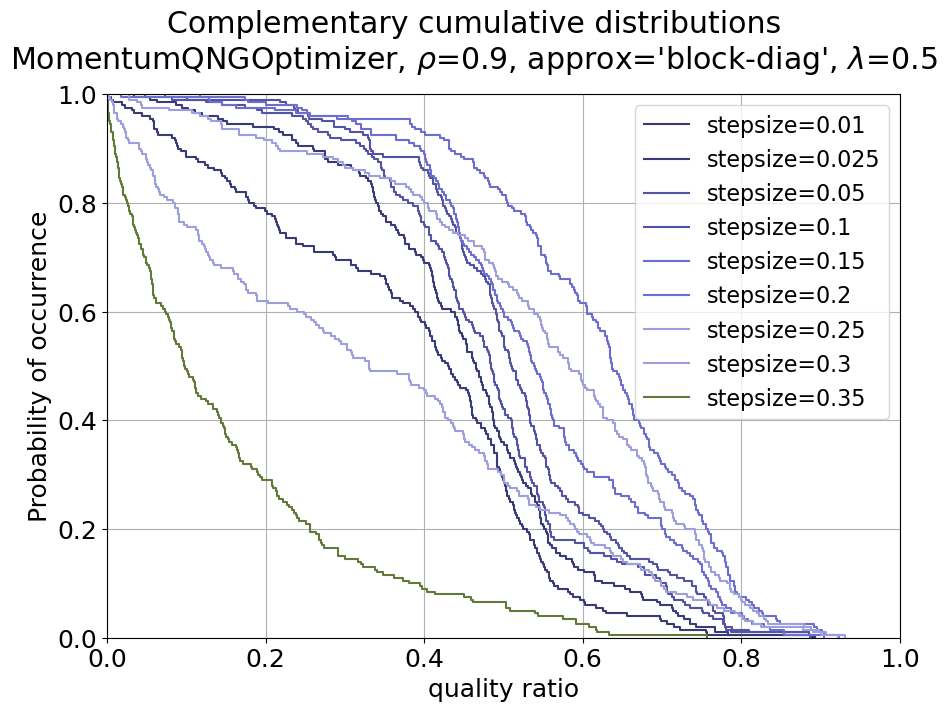

\\?\C:\Users\User\AppData\Roaming\jupyterlab-desktop\envs\env_penelope\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


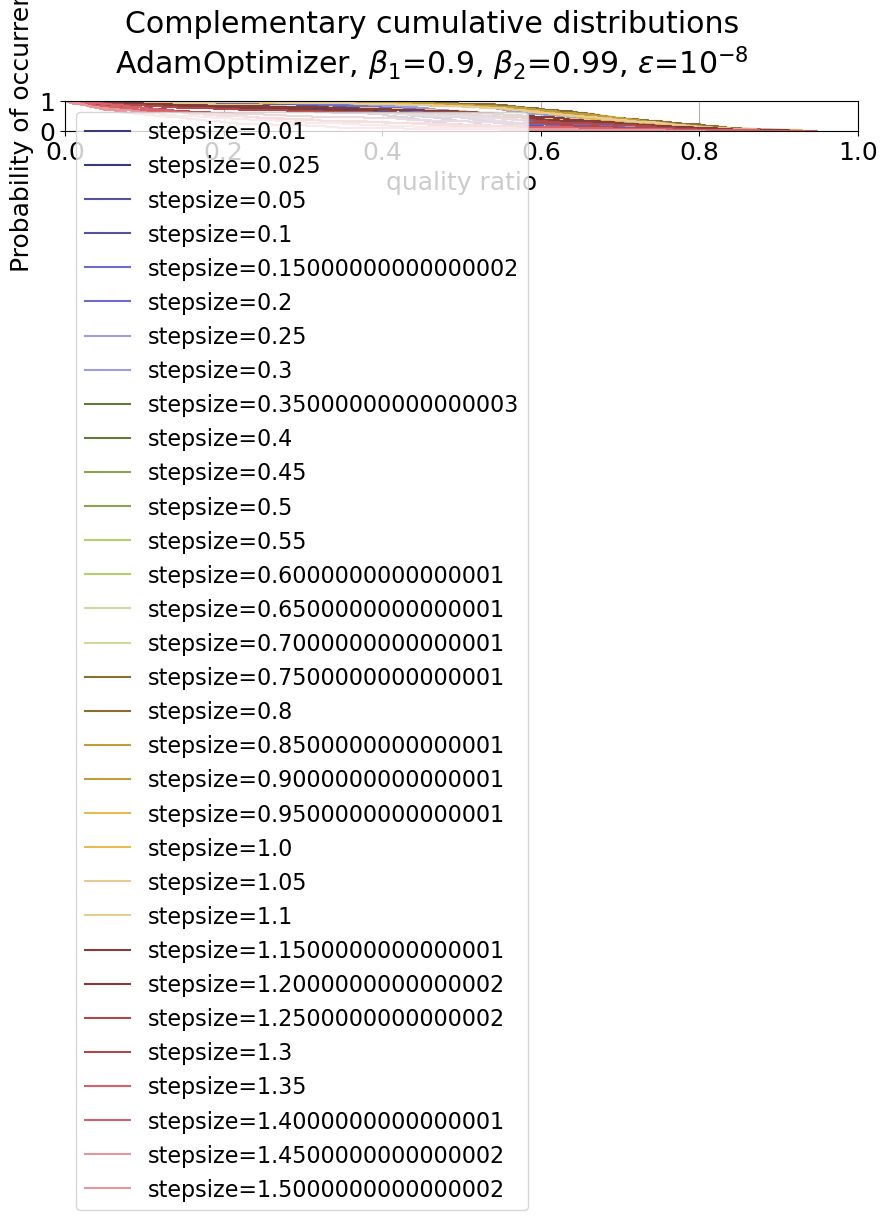

In [11]:
import matplotlib as mpl
from datetime import date
import ipynbname

mpl.rcParams['font.size'] = 18

prefix_name = "mvc_4" #ipynbname.name() + "_" # + str(date.today()) + "_"

cmap = mpl.colormaps['tab20b']
colors = cmap(np.linspace(0, 1, 40))

for i,session in enumerate(sessions):
    fig = plt.figure(figsize=(9, 7), layout="compressed")
    axs = fig.subplots(1, 1, sharex=True, sharey=True)
    
    # Cumulative distributions.
    
    for j,stepsize in enumerate(session["stepsizes"]):
        axs.ecdf(sessions_quality[i][j],complementary=True, color=colors[j], label="stepsize="+str(stepsize) )
        
    # Label the figure.
    title = "Complementary cumulative distributions\n" + session["optimizer"]
    if(len(session["params_name"]) > 0):
        title += ", " + session["params_name"]
    
    fig.suptitle(title)
    
    axs.grid(True)
    axs.legend(fontsize=16)
    axs.set_xlabel("quality ratio")
    axs.set_ylabel("Probability of occurrence")
    axs.label_outer()
    axs.set_xlim(0.0, 1)
    plt.show()
    #fig.savefig(prefix_name + session["optimizer"]+"_ccdf_quality.png",format='png',dpi=300)
    #fig.savefig(prefix_name + session["optimizer"]+"_ccdf_quality.pdf",format='pdf',dpi=300)
    #fig.savefig(prefix_name + session["optimizer"]+"_ccdf_quality.eps",format='eps',dpi=300)

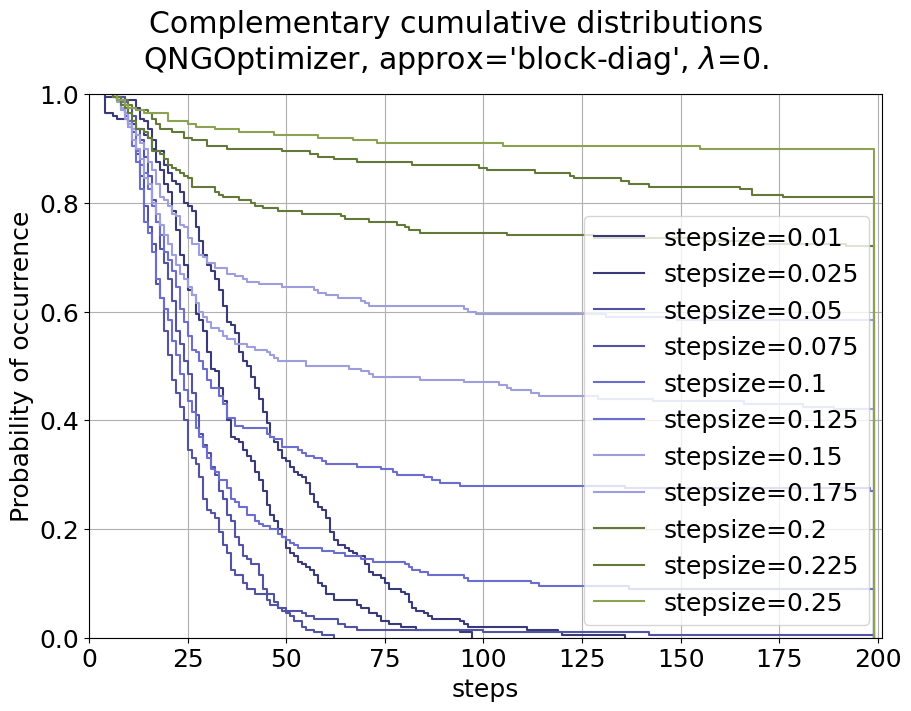

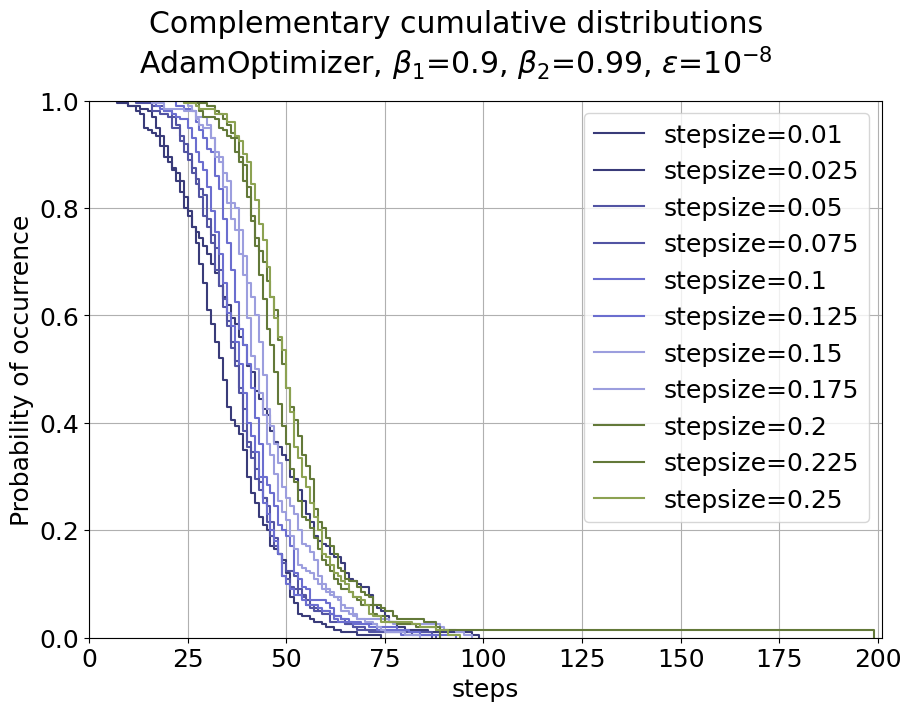

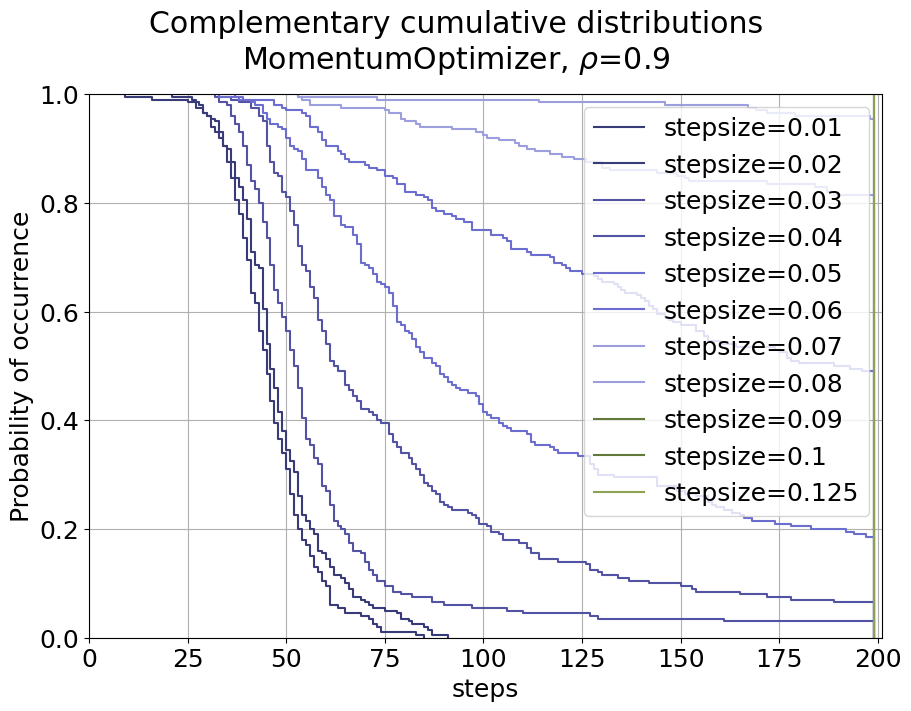

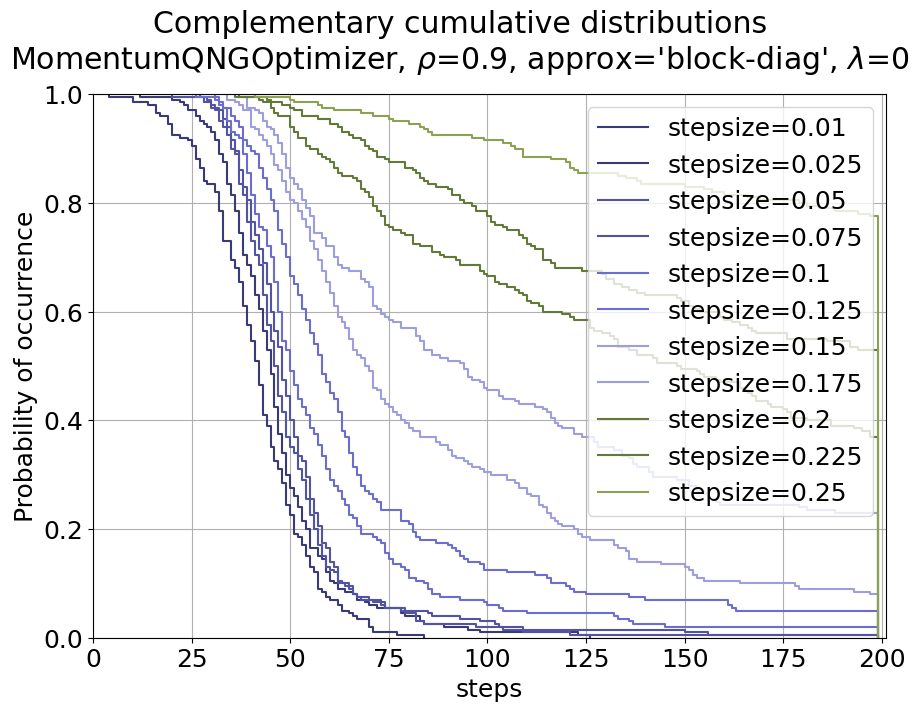

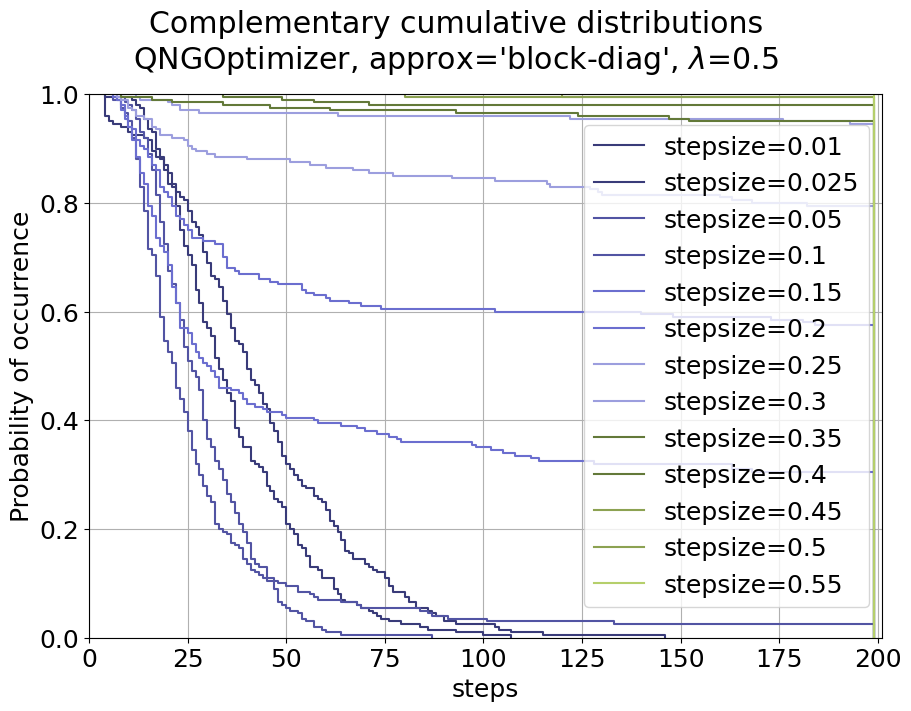

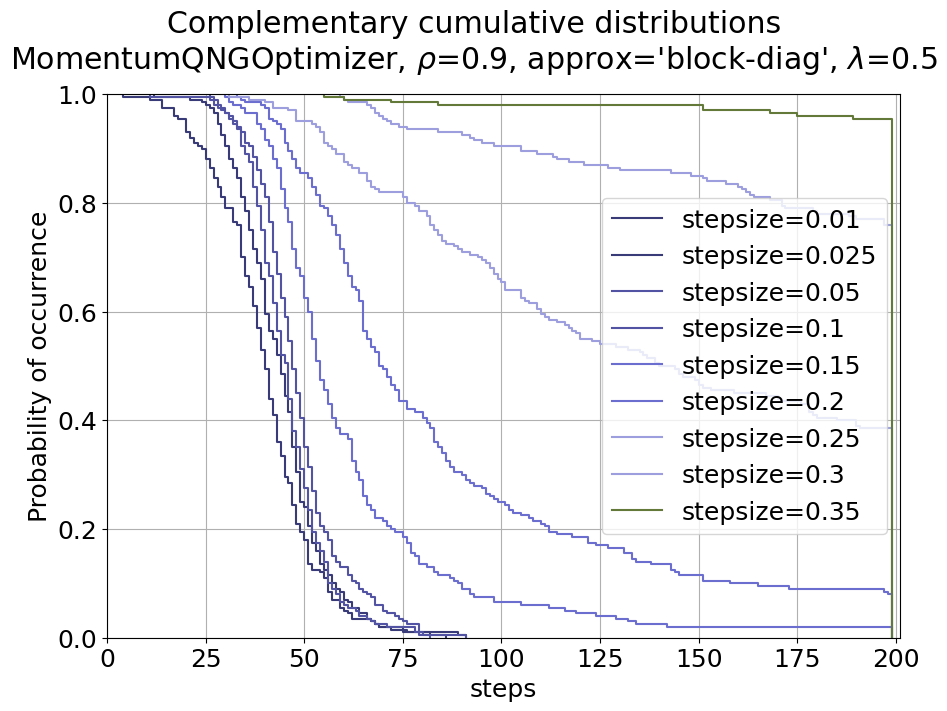

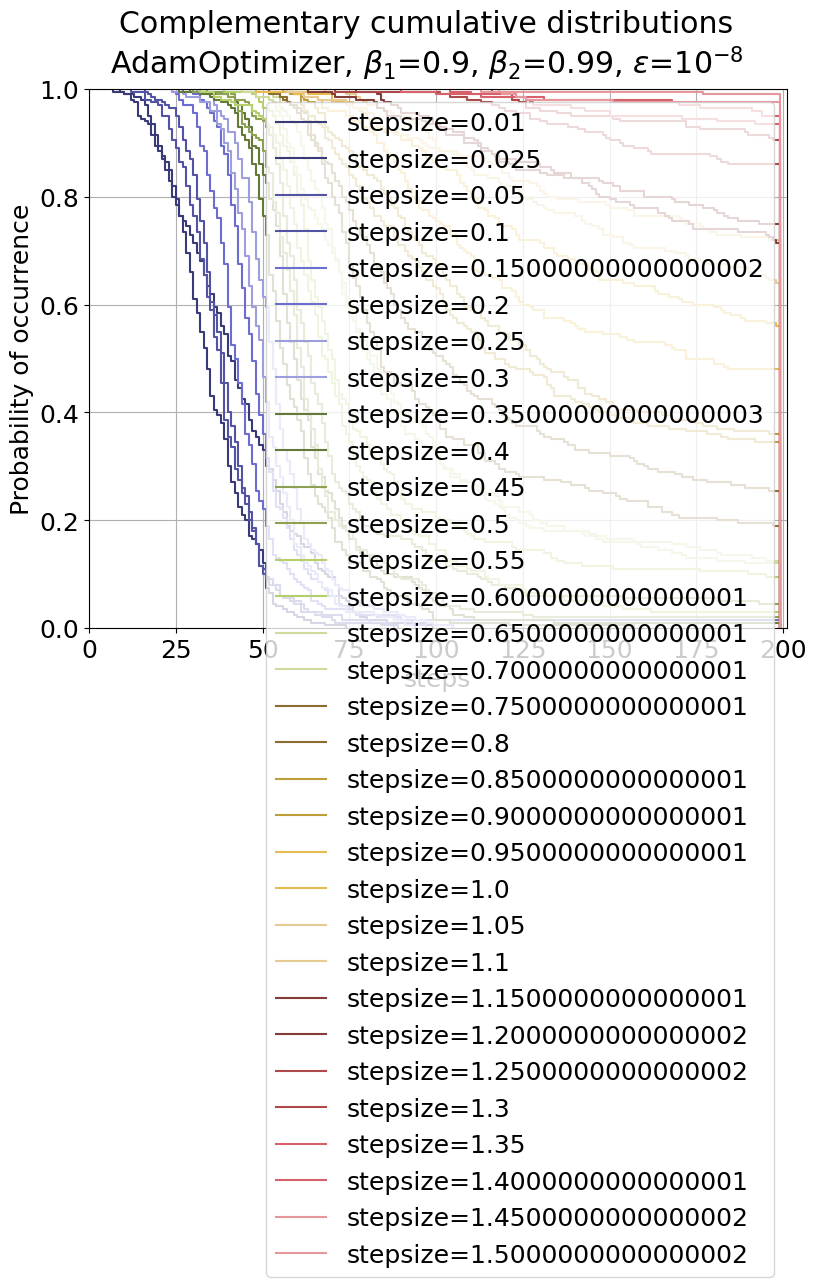

In [12]:
import matplotlib as mpl

cmap = mpl.colormaps['tab20b']
colors = cmap(np.linspace(0, 1, 40))

for i,session in enumerate(sessions):
    fig = plt.figure(figsize=(9, 7), layout="compressed")
    axs = fig.subplots(1, 1, sharex=True, sharey=True)
    
    # Cumulative distributions.
    
    for j,stepsize in enumerate(session["stepsizes"]):
        axs.ecdf(sessions_steps[i][j],complementary=True, color=colors[j], label="stepsize="+str(stepsize) )
        
    # Label the figure.
    title = "Complementary cumulative distributions\n" + session["optimizer"]
    if(len(session["params_name"]) > 0):
        title += ", " + session["params_name"]
    
    fig.suptitle(title)
    
    axs.grid(True)
    axs.legend()
    axs.set_xlabel("steps")
    axs.set_ylabel("Probability of occurrence")
    axs.label_outer()
    axs.set_xlim(0.0, 201)
    plt.show()
    #fig.savefig(prefix_name + session["optimizer"]+"_ccdf_steps.png",format='png',dpi=300)
    #fig.savefig(prefix_name + session["optimizer"]+"_ccdf_steps.pdf",format='pdf',dpi=300)
    #fig.savefig(prefix_name + session["optimizer"]+"_ccdf_steps.eps",format='eps',dpi=300)

<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
C:\Users\User\AppData\Local\Temp\ipykernel_19656\1053875855.py:12: SyntaxWarning: invalid escape sequence '\e'
  axs[0][0].ecdf(sessions_quality[indices[0]][j],complementary=True, color=colors[j], label=f"$\eta$={stepsize:.3}" )
C:\Users\User\AppData\Local\Temp\ipykernel_19656\1053875855.py:14: SyntaxWarning: invalid escape sequence '\e'
  axs[0][1].ecdf(sessions_quality[indices[1]][j],complementary=True, color=colors[j], label=f"$\eta$={stepsize:.3}" )
C:\Users\User\AppData\Local\Temp\ipykernel_19656\1053875855.py:16: SyntaxWarning: invalid escape sequence '\e'
  axs[1][1].ecdf(sessio

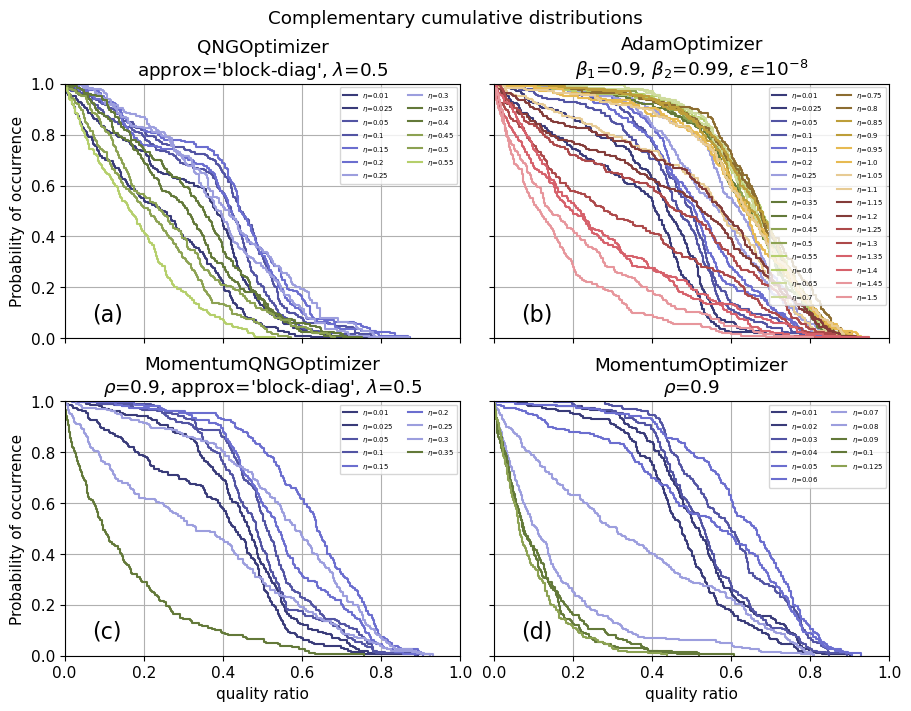

In [13]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 11

fig = plt.figure(figsize=(9, 7), layout="compressed")
axs = fig.subplots(2, 2, sharex=True, sharey=True)

# Cumulative distributions.
cmap = mpl.colormaps['tab20b']
colors = cmap(np.linspace(0, 1, 40))
indices = [4,6,2,5]
for j,stepsize in enumerate(sessions[indices[0]]["stepsizes"]):
    axs[0][0].ecdf(sessions_quality[indices[0]][j],complementary=True, color=colors[j], label=f"$\eta$={stepsize:.3}" )
for j,stepsize in enumerate(sessions[indices[1]]["stepsizes"]):
    axs[0][1].ecdf(sessions_quality[indices[1]][j],complementary=True, color=colors[j], label=f"$\eta$={stepsize:.3}" )
for j,stepsize in enumerate(sessions[indices[2]]["stepsizes"]):
    axs[1][1].ecdf(sessions_quality[indices[2]][j],complementary=True, color=colors[j], label=f"$\eta$={stepsize:.3}" )
for j,stepsize in enumerate(sessions[indices[3]]["stepsizes"]):
    axs[1][0].ecdf(sessions_quality[indices[3]][j],complementary=True, color=colors[j], label=f"$\eta$={stepsize:.3}" )

session_id = [4,6,5,2]
axs[0][0].text(0.07,0.07,"(a)",fontsize=16)
axs[0][1].text(0.07,0.07,"(b)",fontsize=16)
axs[1][0].text(0.07,0.07,"(c)",fontsize=16)
axs[1][1].text(0.07,0.07,"(d)",fontsize=16)
fig.suptitle("Complementary cumulative distributions")
for i in range(2):
    for j in range(2):
        axs[j][i].grid(True)
        axs[j][i].set_xlabel("quality ratio")
        axs[j][i].set_ylabel("Probability of occurrence")
        axs[j][i].label_outer()
        axs[j][i].set_xlim(0.0, 1)
        axs[j][i].legend(loc="upper right",fontsize=5,ncol=2)
        session = sessions[session_id[i*2+j]]
        title = session["optimizer"]
        if(len(session["params_name"]) > 0):
            title += "\n" + session["params_name"]
        axs[i][j].set_title(title)
        
plt.show()
#fig.savefig(prefix_name + "quality_ccdf.png",format='png',dpi=300)
fig.savefig(prefix_name + "_quality_ccdf.pdf",format='pdf',dpi=300)
#fig.savefig(prefix_name + "quality_ccdf.eps",format='eps',dpi=300)

<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
C:\Users\User\AppData\Local\Temp\ipykernel_19656\3033712981.py:12: SyntaxWarning: invalid escape sequence '\e'
  axs[0][0].ecdf(sessions_steps[indices[0]][j],complementary=True, color=colors[j], label=f"$\eta$={stepsize:.3}" )
C:\Users\User\AppData\Local\Temp\ipykernel_19656\3033712981.py:14: SyntaxWarning: invalid escape sequence '\e'
  axs[0][1].ecdf(sessions_steps[indices[1]][j],complementary=True, color=colors[j], label=f"$\eta$={stepsize:.3}" )
C:\Users\User\AppData\Local\Temp\ipykernel_19656\3033712981.py:16: SyntaxWarning: invalid escape sequence '\e'
  axs[1][1].ecdf(sessions_s

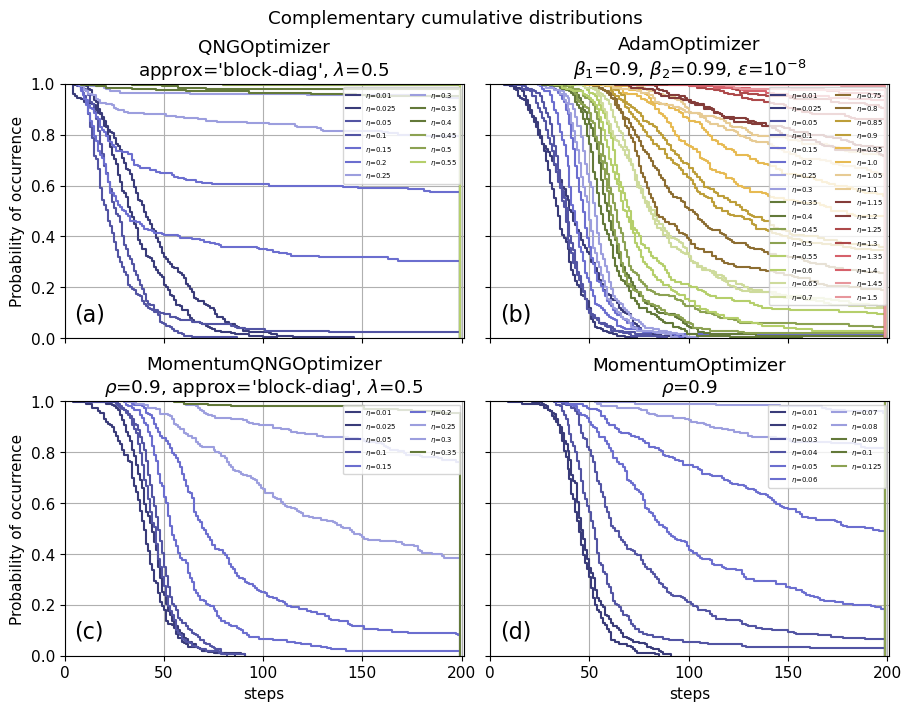

In [14]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 11

fig = plt.figure(figsize=(9, 7), layout="compressed")
axs = fig.subplots(2, 2, sharex=True, sharey=True)

# Cumulative distributions.
cmap = mpl.colormaps['tab20b']
colors = cmap(np.linspace(0, 1, 40))
indices = [4,6,2,5]
for j,stepsize in enumerate(sessions[indices[0]]["stepsizes"]):
    axs[0][0].ecdf(sessions_steps[indices[0]][j],complementary=True, color=colors[j], label=f"$\eta$={stepsize:.3}" )
for j,stepsize in enumerate(sessions[indices[1]]["stepsizes"]):
    axs[0][1].ecdf(sessions_steps[indices[1]][j],complementary=True, color=colors[j], label=f"$\eta$={stepsize:.3}" )
for j,stepsize in enumerate(sessions[indices[2]]["stepsizes"]):
    axs[1][1].ecdf(sessions_steps[indices[2]][j],complementary=True, color=colors[j], label=f"$\eta$={stepsize:.3}" )
for j,stepsize in enumerate(sessions[indices[3]]["stepsizes"]):
    axs[1][0].ecdf(sessions_steps[indices[3]][j],complementary=True, color=colors[j], label=f"$\eta$={stepsize:.3}" )

session_id = [4,6,5,2]

axs[0][0].text(5,0.07,"(a)",fontsize=16)
axs[0][1].text(5,0.07,"(b)",fontsize=16)
axs[1][0].text(5,0.07,"(c)",fontsize=16)
axs[1][1].text(5,0.07,"(d)",fontsize=16)
fig.suptitle("Complementary cumulative distributions")
for i in range(2):
    for j in range(2):
        axs[j][i].grid(True)
        axs[j][i].set_xlabel("steps")
        axs[j][i].set_ylabel("Probability of occurrence")
        axs[j][i].label_outer()
        axs[j][i].set_xlim(0.0, 201)
        axs[j][i].legend(loc="upper right",fontsize=5,ncol=2)
        session = sessions[session_id[i*2+j]]
        title = session["optimizer"]
        if(len(session["params_name"]) > 0):
            title += "\n" + session["params_name"]
        axs[i][j].set_title(title)
        
plt.show()
#fig.savefig(prefix_name + "steps_ccdf.png",format='png',dpi=300)
fig.savefig(prefix_name + "_steps_ccdf.pdf",format='pdf',dpi=300)
#fig.savefig(prefix_name + "steps_ccdf.eps",format='eps',dpi=300)

In [15]:
#!pip install torch

<>:43: SyntaxWarning: invalid escape sequence '\e'
<>:43: SyntaxWarning: invalid escape sequence '\e'
C:\Users\User\AppData\Local\Temp\ipykernel_19656\2363133296.py:43: SyntaxWarning: invalid escape sequence '\e'
  axs.set_xlabel("learning rate $\eta$",fontsize=20)


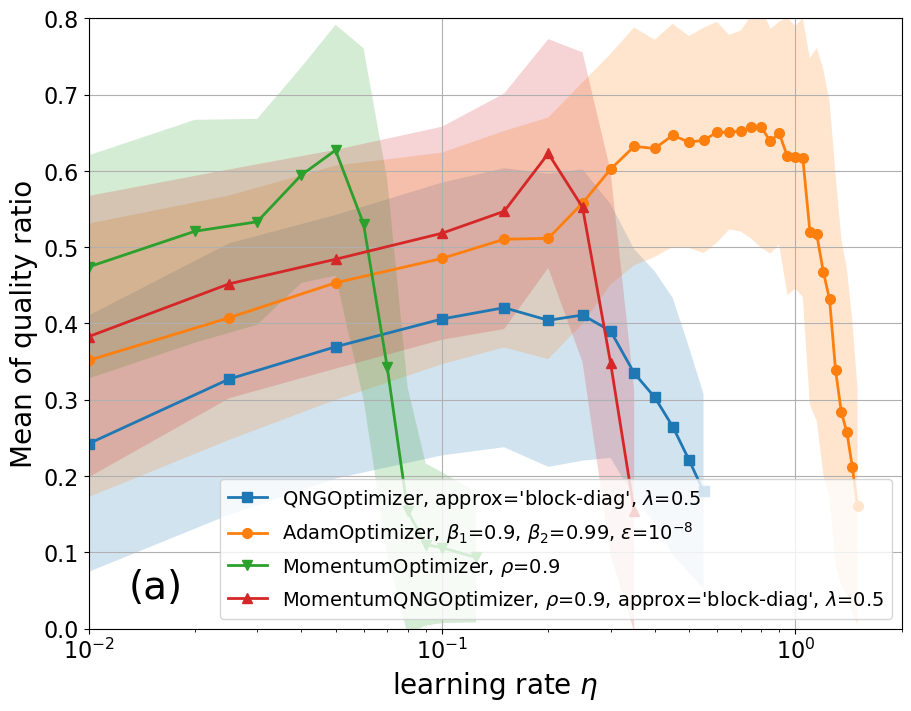

In [16]:
import matplotlib as mpl
import statistics
import math
import torch

mpl.rcParams['font.size'] = 16

cmap = mpl.colormaps['tab20b']
colors = cmap(np.linspace(0, 1, 20))
fig = plt.figure(figsize=(9, 7), layout="compressed")
axs = fig.subplots(1, 1, sharex=True, sharey=True)
axs.text(0.013,0.04,"(a)",fontsize=28)
format_plot = ["s","o","v","^"]
indices = [4,6,2,5]
#for i,session in enumerate([sessions[4],sessions[6],sessions[1],sessions[5]]):
for index,i in enumerate(indices): 
    session = sessions[i]
    ave_session = []
    stdev_session = []
    ave_plus_stdev_session = []
    ave_minus_stdev_session = []    
    for j,stepsize in enumerate(session["stepsizes"]):
        quality = []
        for k in range(init_count):
            quality.append(float(sessions_quality[i][j][k]))
        ave_val = statistics.mean(quality)
        stdev_val = statistics.stdev(quality)
        ave_session.append(ave_val)
        if(stdev_val == 'NaN'):
            stdev_val = 0
        stdev_session.append(stdev_val)
        ave_minus_stdev_session.append(ave_val - stdev_val)
        ave_plus_stdev_session.append(ave_val + stdev_val)        
    label = session["optimizer"]
    if(len(session["params_name"]) > 0):
        label += ", " + session["params_name"]
    #axs.errorbar(session["stepsizes"],ave_session,yerr=stdev_session,elinewidth=1,label=label,capsize=3,fmt=format_plot[i],ms=7,lw=2)
    axs.plot(session["stepsizes"],ave_session,label=label,marker=format_plot[index],ms=7,lw=2)
    axs.fill_between(session["stepsizes"], ave_minus_stdev_session, ave_plus_stdev_session, alpha=0.2)
    
    axs.grid(True)
    axs.legend(fontsize=14,loc="lower right")
    axs.set_xlabel("learning rate $\eta$",fontsize=20)
    axs.set_ylabel("Mean of quality ratio",fontsize=20)
    #axs.label_outer()
    axs.set_xscale('log')
    axs.set_xlim(0.01, 2)
    axs.set_ylim(0.0, 0.8)
plt.show()
fig.savefig(prefix_name+"_ave_quality.png",format='png',dpi=300)
fig.savefig(prefix_name+"_ave_quality.pdf",format='pdf',dpi=300)
#fig.savefig(prefix_name+"_ave_quality.eps",format='eps',dpi=300)

<>:41: SyntaxWarning: invalid escape sequence '\e'
<>:41: SyntaxWarning: invalid escape sequence '\e'
C:\Users\User\AppData\Local\Temp\ipykernel_19656\3072843572.py:41: SyntaxWarning: invalid escape sequence '\e'
  axs.set_xlabel("learning rate $\eta$",fontsize=20)


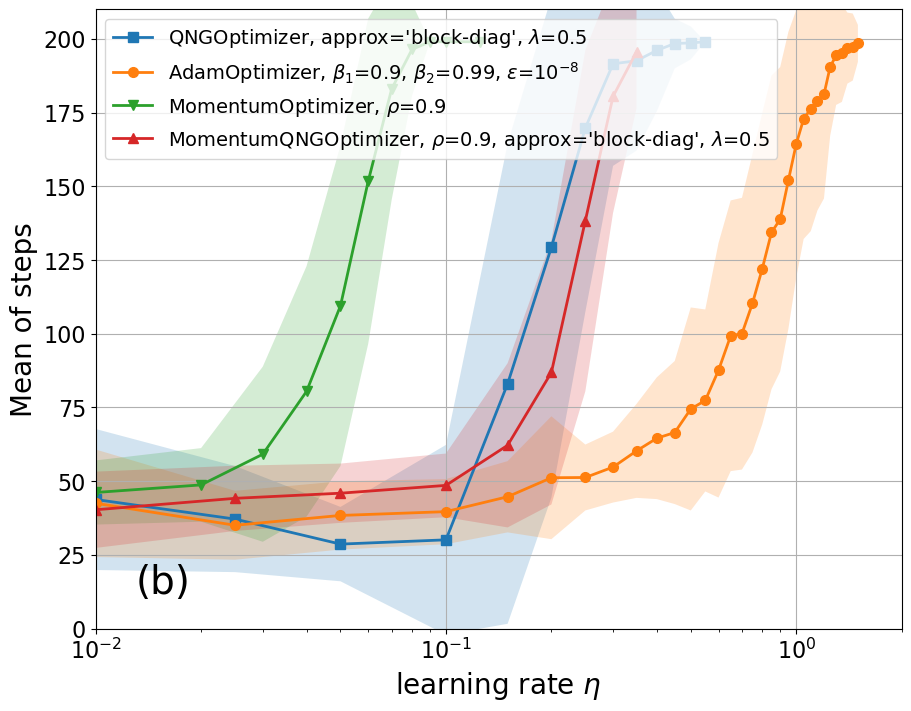

In [17]:
import matplotlib as mpl
import statistics
import math
import torch

cmap = mpl.colormaps['tab20b']
colors = cmap(np.linspace(0, 1, 20))
fig = plt.figure(figsize=(9, 7), layout="compressed")
axs = fig.subplots(1, 1, sharex=True, sharey=True)
axs.text(0.013,12.0,"(b)",fontsize=28)
format_plot = ["s","o","v","^"]
indices = [4,6,2,5]
#for i,session in enumerate([sessions[4],sessions[6],sessions[1],sessions[5]]):
for index,i in enumerate(indices):  
    session = sessions[i]
    ave_session = []
    stdev_session = []
    ave_plus_stdev_session = []
    ave_minus_stdev_session = []    
    for j,stepsize in enumerate(session["stepsizes"]):
        arr_steps = []
        for k in range(init_count):
            arr_steps.append(float(sessions_steps[i][j][k]))
        ave_val = statistics.mean(arr_steps)
        stdev_val = statistics.stdev(arr_steps)
        ave_session.append(ave_val)
        if(stdev_val == 'NaN'):
            stdev_val = 0
        stdev_session.append(stdev_val)
        ave_minus_stdev_session.append(ave_val - stdev_val)
        ave_plus_stdev_session.append(ave_val + stdev_val)                
    label = session["optimizer"]
    if(len(session["params_name"]) > 0):
        label += ", " + session["params_name"]
    #axs.errorbar(session["stepsizes"],ave_session,yerr=stdev_session,elinewidth=1,label=label,capsize=3,fmt=format_plot[i],ms=7,lw=2)
    axs.plot(session["stepsizes"],ave_session,label=label,marker=format_plot[index],ms=7,lw=2)
    axs.fill_between(session["stepsizes"], ave_minus_stdev_session, ave_plus_stdev_session, alpha=0.2)
  
    axs.grid(True)
    axs.legend(fontsize=14,loc="upper left" )
    axs.set_xlabel("learning rate $\eta$",fontsize=20)
    axs.set_ylabel("Mean of steps",fontsize=20)
    #axs.label_outer()
    axs.set_xscale('log')
    axs.set_xlim(0.01, 2)
    axs.set_ylim(0.0, 210)
plt.show()
fig.savefig(prefix_name+"_ave_steps.png",format='png',dpi=300)
fig.savefig(prefix_name+"_ave_steps.pdf",format='pdf',dpi=300)
#fig.savefig(prefix_name+"_ave_steps.eps",format='eps',dpi=300)